# Intel PyTorch GPU Training and Inference with AMP

This code sample will train a ResNet50 model using the CIFAR10 dataset while using Intel® Extension for PyTorch*. The model is trained using FP32 by default but can also be trained with AMP BF16 precision by passing BF16 parameter in the Train function. Then the same trained model is taken and inference with FP32 and AMP BF16 is done and latency is compared to see the performance improvement with the use of Intel® Xe Matrix Extensions(XMX) for BF16. XMX is supported on BF16 and INT8 data types on Intel discrete GPUs.

## Environment Setup

Ensure the PyTorch kernel is activated before running this notebook.

## Imports, Dataset, Hyperparameters

In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import intel_extension_for_pytorch as ipex
from tqdm import tqdm

/home/gta/miniconda3/envs/ipex-113/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gta/miniconda3/envs/ipex-113/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Hyperparameters and constants
LR = 0.01
MOMENTUM = 0.9
DATA = 'datasets/cifar10/'
epochs=1
batch_size=128

### Check for env setup

In [3]:
torch.xpu.is_available()

True

In [4]:
try:
  device = "xpu" if torch.xpu.is_available() else "cpu" 
  
except:
  device = "cpu"  

if device == "xpu": # Intel dGPU is recognized as device type xpu
  print("IPEX_XPU is present and Intel GPU is available to use for PyTorch")
  device = "gpu"
else: 
  print("using CPU device for PyTorch")


IPEX_XPU is present and Intel GPU is available to use for PyTorch


## Loading the dataset
The CIFAR10 dataset is used for this sample. Dataset is being downloaded from built-in datasets available in the torchvision.datasets module. Batch size will be set to 128.

In [5]:
#Dataloader operations
transform = torchvision.transforms.Compose([
torchvision.transforms.Resize((224, 224)),
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train = True,
        transform=transform,
        download=True,
)
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size
)

test_dataset = torchvision.datasets.CIFAR10(root=DATA, train = False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size )


Files already downloaded and verified
Files already downloaded and verified


## Training the Model
The function below will train the ResNet50 model based on whether it should use CPU or Intel dGPU, and whether to use FP32 or BF16 data type. To use Intel dGPU, we need to transfer model and data to xpu device using `to("xpu")`.To use BF16 in operations on CPU, use the `torch.cpu.amp.autocast()` function to perform forward and backward propagation.

For Intel dGPU, `torch.xpu.amp` provides convenience for auto data type conversion at runtime, allowing deep learning workloads to benefit from lower-precision floating point data types like `torch.float16` or `torch.bfloat16`, which offer lighter calculation workload and smaller memory usage. However, lower-precision data types sacrifice accuracy for performance. The Auto Mixed Precision (AMP) feature automates data type conversions for operators, allowing for a trade-off between accuracy and performance. `torch.xpu.amp.autocast` is a context manager that enables scopes of the script to run with mixed precision, where operations are performed in a data type chosen by the autocast class to improve performance while maintaining accuracy.

In [6]:
"""
Function to run a test case
"""
def trainModel(train_loader, modelName="myModel", device="cpu", dataType="fp32"):
    """
    Input parameters
        train_loader: a torch DataLoader object containing the training data with images and labels
        modelName: a string representing the name of the model
        device: the device to use - cpu or gpu
        dataType: the data type for model parameters, supported values - fp32, bf16
    Return value
        training_time: the time in seconds it takes to train the model
    """

    # Initialize the model and add a fully connected layer for finetuning the model on CIFAR dataset(with 10 classes). Originally, the ResNet50 is trained with ImageNet dataset(1000 classes)   
    model = torchvision.models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(2048,10)
    lin_layer = model.fc
    new_layer = torch.nn.Sequential(
        lin_layer,
        torch.nn.Softmax(dim=1)
    )
    model.fc = new_layer

    #Define loss function and optimization methodology
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    model.train()

    #export model and criterian to XPU device. GPU specific code
    if device == "gpu":
        model = model.to("xpu:0") ## if we have two Intel dGPU device, we can specify xpu:0 or xpu:1
        criterion = criterion.to("xpu:0") 

    #Optimize with BF16 or FP32(default) . BF16 specific code
    if "bf16" == dataType:
        model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
    else:
        model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.float32)

    #Train the model
    num_batches = len(train_loader) * epochs
    

    for i in range(epochs):
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # export data to XPU device. GPU specific code
            if device == "gpu":
                data = data.to("xpu:0")
                target = target.to("xpu:0")

            # Apply Auto-mixed precision(BF16)  
            if "bf16" == dataType:
                with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):

                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

            else:

                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()


            # Showing Average loss after 50 batches
            if 0 == (batch_idx+1) % 50:
                print("Batch %d/%d complete" %(batch_idx+1, num_batches))
                print(f' average loss: {running_loss / 50:.3f}')
                running_loss = 0.0

    # Save a checkpoint of the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, 'checkpoint_%s.pth' %modelName)
    print(f'\n Training finished and model is saved as checkpoint_{modelName}.pth')
    return None


### Model Training with default FP32 precision(Recommended for inference comparison)

In [7]:
#Model Training
print("Training model with FP32 on GPU, will be saved as checkpoint_gpu_rn50.pth")
trainModel(train_loader, modelName="gpu_rn50", device="gpu", dataType="fp32")

Training model with FP32 on GPU, will be saved as checkpoint_gpu_rn50.pth


/home/gta/miniconda3/envs/ipex-113/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gta/miniconda3/envs/ipex-113/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gta/miniconda3/envs/ipex-113/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:484: UserWarning: Split Master Weight feature is not supported on XPU for now, disabled.
  warnings.warn("Split Master Weight feature is not supported on XPU for now, disabled.")
/home/gta/miniconda3/envs/ipex-113/lib/python3.9/

Batch 50/391 complete
 average loss: 2.151
Batch 100/391 complete
 average loss: 1.786
Batch 150/391 complete
 average loss: 1.594
Batch 200/391 complete
 average loss: 1.558
Batch 250/391 complete
 average loss: 1.543
Batch 300/391 complete
 average loss: 1.538
Batch 350/391 complete
 average loss: 1.535

 Training finished and model is saved as checkpoint_gpu_rn50.pth


### Model Training with default AMP BF16(Optional) 

In [8]:
#Model Training
print("Training model with BF16 on GPU, will be saved as checkpoint_gpu_rn50.pth")
trainModel(train_loader, modelName="gpu_rn50", device="gpu", dataType="bf16")

Training model with BF16 on GPU, will be saved as checkpoint_gpu_rn50.pth
Batch 50/391 complete
 average loss: 2.153
Batch 100/391 complete
 average loss: 1.728
Batch 150/391 complete
 average loss: 1.588
Batch 200/391 complete
 average loss: 1.557
Batch 250/391 complete
 average loss: 1.542
Batch 300/391 complete
 average loss: 1.536
Batch 350/391 complete
 average loss: 1.532

 Training finished and model is saved as checkpoint_gpu_rn50.pth


### Model Training on CPU(Optional, if device is CPU) 

In [ ]:
#Model Training
print("Training model on CPU, will be saved as checkpoint_cpu_rn50.pth")
trainModel(train_loader, modelName="cpu_rn50", device="cpu", dataType="fp32")

## FP32 & AMP BF16 Model Evaluation if trained with FP32 precision

### Load model from saved model file

In [9]:
#Load model structure from torchvision and weights from saved checkpoint file
def load_model(cp_file = 'checkpoint_rn50.pth'):
    model = torchvision.models.resnet50()
    model.fc = torch.nn.Linear(2048,10)
    lin_layer = model.fc
    new_layer = torch.nn.Sequential(
        lin_layer,
        torch.nn.Softmax(dim=1)
    )
    model.fc = new_layer

    checkpoint = torch.load(cp_file)
    model.load_state_dict(checkpoint['model_state_dict']) 
    return model


### Applying IPEX optimizations and Converting model to TorchScript(Optional)
TorchScript is a way to create serializable and optimizable models from PyTorch code. Any code written in TorchScript can be saved from your Python process and loaded in a process where there is no Python dependency. `torch.jit.trace` and `torch.jit.freeze` is used for converting the model to TorchScript. `torch.jit.trace` will trace a function and return an executable or ScriptFunction that will be optimized using just-in-time compilation. `torch.jit.freeze` will clone executable or ScriptFunction and attempt to inline the cloned module's submodules, parameters, and attributes as constants in the TorchScript IR Graph.

Intel® Extension for PyTorch* provides optimizations for both eager mode and graph mode, however, compared to eager mode, graph mode in PyTorch normally yields better performance from optimization techniques such as operation fusion, and Intel® Extension for PyTorch* amplified them with more comprehensive graph optimizations. Therefore we recommended you to take advantage of Intel® Extension for PyTorch* with TorchScript. 


In [10]:
def ipex_jit_optimize(model, dataType = "fp32" , device="cpu"):
    model.eval()
    if device=="gpu":
        model = model.to("xpu:0")
    if dataType=="bf16":
        model = ipex.optimize(model, dtype=torch.bfloat16)
    else:
        model = ipex.optimize(model, dtype = torch.float32)
            
    with torch.no_grad():
        d = torch.rand(1, 3, 224, 224)
        if device=="gpu": 
            d = d.to("xpu:0")
            
        if dataType=="bf16": 
          with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16): 
            jit_model = torch.jit.trace(model, d) # JIT trace the optimized model
            jit_model = torch.jit.freeze(jit_model) # JIT freeze the traced model
        else:
          jit_model = torch.jit.trace(model, d) # JIT trace the optimized model
          jit_model = torch.jit.freeze(jit_model) # JIT freeze the traced model              
    return jit_model


### Inference

In [11]:
def inferModel(model, test_loader, device="cpu" , dataType='fp32'):
    correct = 0
    total = 0
    if device == "gpu":
        model = model.to("xpu:0")
    infer_time = 0

    with torch.no_grad():
        num_batches = len(test_loader)
        batches=0
                   
        for i, data in tqdm(enumerate(test_loader)):
            
            # Record time for Inference
            torch.xpu.synchronize()
            start_time = time()
            images, labels = data
            if device =="gpu":
                images = images.to("xpu:0")
                 
            outputs = model(images)
            outputs = outputs.to("cpu") # Need model outputs back to CPU(Host) again to remove Device(GPU) to Host overhead as all the accuracy related computation is going to happen on CPU
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()        
            
            # Record time after finishing batch inference
            torch.xpu.synchronize()
            end_time = time()      

            if i>=3 and i<=num_batches-3: # Ignoring a few start and end batches for consistent and accurate latency measure 
                infer_time += (end_time-start_time)
                batches += 1
            #Skip last few batches     
            if i == num_batches - 3:
                break    

    accuracy = 100 * correct / total
    return accuracy, infer_time*1000/(batches*batch_size)


In [12]:
#Evaluation of different models
def Eval_model(cp_file = 'checkpoint_model.pth', dataType = "fp32" , device="gpu" ):
    model = load_model(cp_file)
    model = ipex_jit_optimize(model, dataType , device)
    accuracy, latency = inferModel(model, test_loader, device, dataType )
    print(f' Model accuracy: {accuracy} and Average Inference latency: {latency} \n'  )
    return accuracy, latency

### Accuracy and Inference latency check

For FP32 model on GPU

In [13]:
#For FP32 model on GPU
print("Model evaluation with FP32 on GPU")
acc_fp32, fp32_avg_latency = Eval_model(cp_file = 'checkpoint_gpu_rn50.pth', dataType = "fp32" , device="gpu")

Model evaluation with FP32 on GPU


76it [00:16,  4.55it/s]

 Model accuracy: 93.12094155844156 and Average Inference latency: 0.5485470834616069 



For BF16 model on GPU

In [14]:
#For AMP BF16 model on GPU
print("Model evaluation with AMP BF16 on GPU")
acc_bf16, bf16_avg_latency = Eval_model(cp_file = 'checkpoint_gpu_rn50.pth', dataType = "bf16" , device="gpu")

Model evaluation with AMP BF16 on GPU


76it [00:11,  6.89it/s]

 Model accuracy: 93.13108766233766 and Average Inference latency: 0.13110522382162712 



Model Evaluation on CPU(optional, if trained on CPU)

In [15]:
#For model inference on CPU
print("Model evaluation with FP32 on CPU")
Eval_model(cp_file = 'checkpoint_cpu_rn50.pth', dataType = "fp32" , device="cpu")

Model evaluation with FP32 on CPU


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_cpu_rn50.pth'

## Summary of Results for GPU
The following cells below will summarize the training times for all three cases and display graphs to show the performance speedup.

In [18]:
#Summary 
print("Summary")
print(f'Inference average latecy for FP32  on GPU is:  {fp32_avg_latency} ')
print(f'Inference average latency for AMP BF16 on GPU is:  {bf16_avg_latency} ')

speedup_from_amp_bf16 = fp32_avg_latency / bf16_avg_latency
print("Inference with BF16 is %.2fX faster than FP32 on GPU" %speedup_from_amp_bf16)

Summary
Inference average latecy for FP32  on GPU is:  0.5485470834616069 
Inference average latency for AMP BF16 on GPU is:  0.13110522382162712 
Inference with BF16 is 4.18X faster than FP32 on GPU


<BarContainer object of 2 artists>

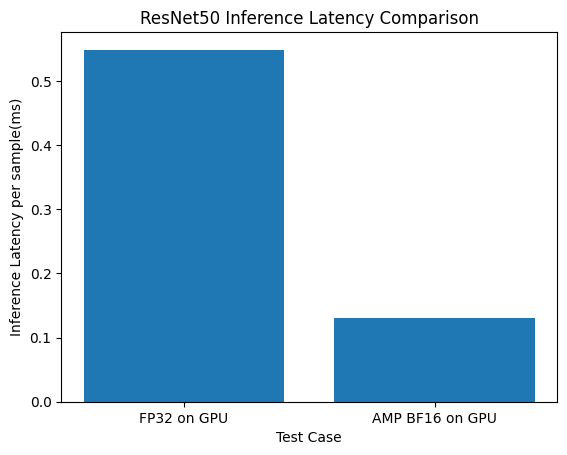

In [19]:
plt.figure()
plt.title("ResNet50 Inference Latency Comparison")
plt.xlabel("Test Case")
plt.ylabel("Inference Latency per sample(ms)")
plt.bar(["FP32 on GPU", "AMP BF16 on GPU"], [fp32_avg_latency, bf16_avg_latency])


Accuracy drop with AMP BF16 is: -0.010146103896104819


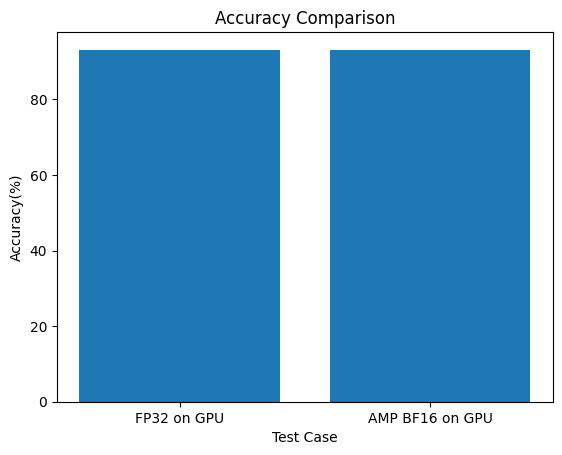

In [20]:
plt.figure()
plt.title("Accuracy Comparison")
plt.xlabel("Test Case")
plt.ylabel("Accuracy(%)")
plt.bar(["FP32 on GPU", "AMP BF16 on GPU"], [acc_fp32, acc_bf16])
print(f'Accuracy drop with AMP BF16 is: {acc_fp32-acc_bf16}')

<BarContainer object of 2 artists>

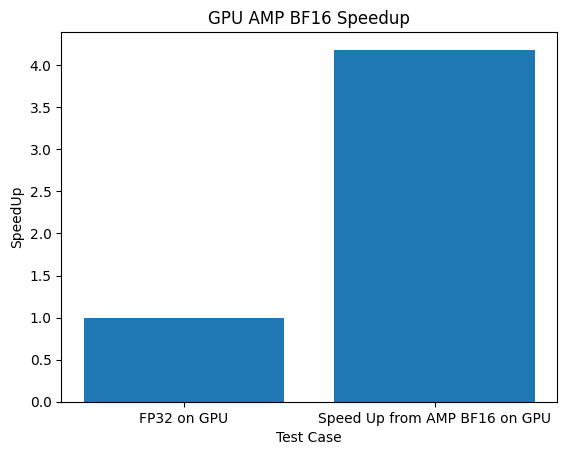

In [21]:
speedup_from_bf16_on_gpu = fp32_avg_latency/bf16_avg_latency
plt.figure()
plt.title("GPU AMP BF16 Speedup")
plt.xlabel("Test Case")
plt.ylabel("SpeedUp")
plt.bar(["FP32 on GPU", "Speed Up from AMP BF16 on GPU"], [1, speedup_from_bf16_on_gpu])

In [17]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
